In [17]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision.datasets as dset
from data import image_manipulation
from data import dataloader as img_dataloader
from torch.autograd import Variable
from tqdm import tqdm, tdm

ImportError: cannot import name 'tdm' from 'tqdm' (/media/imsanskar/My files/Projects/Minor/env/lib/python3.9/site-packages/tqdm/__init__.py)

In [2]:
# random seed for reproducibility
random_seed = 69

np.random.seed(random_seed)

In [65]:
# no of workers for dataloader
no_of_workers = 4

# root of the data
data_root = "data/train/"

# batch size
batch_size = 1

#no of epochs
n_epochs = 10

# learning rate
lr = 0.0001

# betas for adam
beta_1 = 0.5
beta_2 = 0.999

# image size
image_height = 256
image_width = 256

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=data_root,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True,
                                         num_workers = no_of_workers)

In [41]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [5]:
class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize = True, dropout = 0.0):
        super(UNetDown, self).__init__()
        layers = [
            nn.Conv2d(in_size, out_size, 4, 2, 1, bias = False)
        ]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
            
        layers.append(nn.LeakyReLU(0.2))
        
        if dropout:
            layers.append(nn.Dropout(dropout))
            
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [6]:
class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout = 0.0):
        super(UNetUp, self).__init__()

        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)
        
    
    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

In [7]:
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()
        
        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A.cuda(), img_B.cuda()), 1)
        return self.model(img_input)

## Model Train

In [97]:
#initialize model classes
generator = GeneratorUNet()
discriminator = Discriminator()

# initialize weights
if os.path.exists("saved_models/generator.pth"):
    print("Generator Found")
    generator.load_state_dict(torch.load("saved_models/generator.pth"))
else:
    generator.apply(weights_init_normal)
                                         
if os.path.exists("saved_models/discriminator.pth"):
    print("Discriminator Found")
    discriminator.load_state_dict(torch.load("saved_models/discriminator.pth"))
else:
    discriminator.apply(weights_init_normal)

# cuda
cuda = True if torch.cuda.is_available() else False

# model loss functions
loss_fn_generator = torch.nn.MSELoss()
loss_fn_disc = torch.nn.MSELoss() #pixel wise loss

# to cuda if cuda is avaiable
if cuda:
    generator.cuda()
    discriminator.cuda()
    loss_fn_disc.cuda()
    loss_fn_generator.cuda()
    
# optimizers
optimier_G = torch.optim.Adam(generator.parameters(), betas=(beta_1, beta_2), lr=lr)
optimier_D = torch.optim.Adam(discriminator.parameters(), betas=(beta_1, beta_2), lr=lr)

# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 50

# Calculate output of image discriminator (PatchGAN)
patch = (1, image_height // 2 ** 4, image_width // 2 ** 4)

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Generator Found
Discriminator Found


In [98]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((image_width, image_height))
])

pair_image_dataloader = img_dataloader.ImageDataset("./data/train/old_images", "./data/train/reconstructed_images", transform)

In [99]:
for epoch in range(n_epochs):
    for i, batch in tqdm(enumerate(pair_image_dataloader)):
        real_A = batch['A'] # old image
        real_B = batch['B'] # new image
        
        # train generator
        optimier_G.zero_grad()
        
         # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *patch))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *patch))), requires_grad=False)
        
        
        # GAN loss
        fake_B = generator(real_A.unsqueeze(0).cuda()) # fake sample generated by generator
        pred_fake = discriminator(fake_B, real_B.unsqueeze(0)) # prediction using discriminator
        loss_generator = loss_fn_generator(pred_fake, valid) # check if the sample is valid or not
        
        loss_pixel = loss_fn_disc(fake_B.cuda(), real_B.cuda()) # calculate the pixel wise loss
        
        # total loss
        loss_G = loss_generator + lambda_pixel * loss_pixel
        
        loss_G.backward()
        optimier_G.step()
        
        ## Train discriminator
        optimier_D.zero_grad()
        
        # Real loss
        pred_real = discriminator(real_B.unsqueeze(0), real_A.unsqueeze(0))
        loss_real = loss_fn_generator(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(fake_B.detach(), real_A.unsqueeze(0))
        loss_fake = loss_fn_generator(pred_fake, fake)

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake)
        
        loss_D.backward()
        optimier_D.step()
        
        if i % 300 ==  0 and i > 0:
            break
            
        if i % 100 == 0 and i:
            print(f"Error: {torch.linalg.norm(loss_G).item()}, epoch: {epoch}, itr: {i}")

0it [00:00, ?it/s]/media/imsanskar/My files/Projects/Minor/env/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([3, 1, 16, 16])) that is different to the input size (torch.Size([1, 1, 16, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/media/imsanskar/My files/Projects/Minor/env/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([3, 256, 256])) that is different to the input size (torch.Size([1, 3, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
102it [00:07, 13.25it/s]

Error: 1.2246698141098022, epoch: 0, itr: 100


202it [00:15, 13.07it/s]

Error: 1.2667664289474487, epoch: 0, itr: 200


300it [00:22, 13.11it/s]
102it [00:07, 13.32it/s]

Error: 1.1613414287567139, epoch: 1, itr: 100


202it [00:15, 13.19it/s]

Error: 1.1821112632751465, epoch: 1, itr: 200


300it [00:22, 13.20it/s]
102it [00:07, 13.05it/s]

Error: 1.1420750617980957, epoch: 2, itr: 100


202it [00:15, 13.32it/s]

Error: 1.0851181745529175, epoch: 2, itr: 200


300it [00:22, 13.13it/s]
102it [00:07, 12.95it/s]

Error: 1.1708757877349854, epoch: 3, itr: 100


202it [00:15, 12.93it/s]

Error: 1.2946404218673706, epoch: 3, itr: 200


300it [00:23, 12.92it/s]
102it [00:07, 12.91it/s]

Error: 1.522009015083313, epoch: 4, itr: 100


202it [00:15, 12.69it/s]

Error: 1.5138607025146484, epoch: 4, itr: 200


300it [00:23, 12.82it/s]
102it [00:07, 12.99it/s]

Error: 1.6332628726959229, epoch: 5, itr: 100


202it [00:15, 12.86it/s]

Error: 1.6879363059997559, epoch: 5, itr: 200


300it [00:23, 12.90it/s]
102it [00:07, 12.95it/s]

Error: 1.6691639423370361, epoch: 6, itr: 100


202it [00:15, 13.11it/s]

Error: 1.6532171964645386, epoch: 6, itr: 200


300it [00:22, 13.07it/s]
102it [00:07, 12.82it/s]

Error: 1.9646120071411133, epoch: 7, itr: 100


202it [00:15, 12.93it/s]

Error: 1.9372215270996094, epoch: 7, itr: 200


300it [00:23, 12.90it/s]
102it [00:07, 12.69it/s]

Error: 2.03995680809021, epoch: 8, itr: 100


202it [00:15, 12.76it/s]

Error: 1.649083137512207, epoch: 8, itr: 200


300it [00:23, 12.74it/s]
102it [00:08, 12.71it/s]

Error: 1.7832512855529785, epoch: 9, itr: 100


202it [00:15, 12.76it/s]

Error: 1.7706376314163208, epoch: 9, itr: 200


300it [00:23, 12.74it/s]


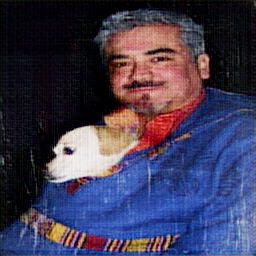

In [103]:
image_manipulation.np_to_pil(generator(pair_image_dataloader[0]['A'].unsqueeze(0).cuda()).detach().cpu().numpy()[0])

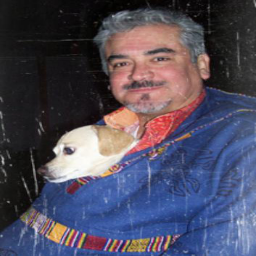

In [102]:
image_manipulation.np_to_pil(pair_image_dataloader[0]['A'].detach().cpu().numpy())

In [104]:
torch.save(generator.state_dict(), "saved_models/generator.pth")
torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")

In [95]:
os.path.exists("saved_models/generator.pth")

True